# Data Analysis
Analysis of line scans taken at the beam. See the `README` in the `Experimental Data` folder.

In [1]:
import utils
from importlib import reload

import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import *

from scipy.interpolate import interp1d
from scipy.optimize import basinhopping

utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Load Reference Data

In [3]:
exp = parse_file('Reference Data/As_exp_standards_normalized.dat')
sim = parse_file('Reference Data/As_edge_sim_standards_phases_normalized.dat')

energy = np.array(sim['X1'], dtype=float)

sim_data_columns = [colm for colm in sim.columns if len(colm.replace('X', '')) > 3]
Sim_Refs = np.array(sim[sim_data_columns], dtype=float).T

exp_data_columns = [colm for colm in exp.columns if len(colm.replace('X', '')) > 3]
Exp_Refs = np.array(exp[exp_data_columns], dtype=float).T

refs = np.concatenate((Sim_Refs, Exp_Refs), axis=0)

Energy = np.linspace(11863, 11915, 5201)
Energy_exp = np.array([11866.5, 11870., 11873.5, 11876.5, 11879., 11885.5, 11900., 11904., 11909.5])

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)
Refs_exp = interperlator(Energy_exp)

print(f"Resolution: {Energy[1] - Energy[0]}")

data_columns = sim_data_columns + exp_data_columns

Resolution: 0.010000000000218279


### Visualize References

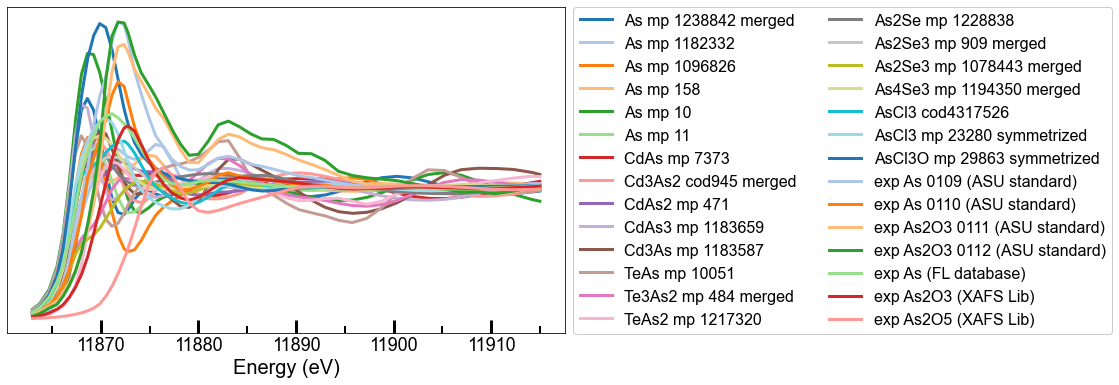

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'
    ax.plot(Energy, ref, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
format_axis(ax, ticks=(5,10))
plt.show()

## Analyze references taken at beam

In [4]:
standard_fnames = ['lineAs_metal_scan006.mda.csv', 'lineCd3As2_scan008.mda.csv',
                   'lineAs2O3_scan009.mda.csv', 'lineAs3Te2_scan011.mda.csv']
standards = ['As metal', '$Cd_3As_2$', '$As_2O_3$', '$As_3Te_2$']
dfs = [pd.read_csv(f'Experimental data/Arsenic standards/{filename}') for filename in standard_fnames]
dfs = [preprocess_df(df) for df in dfs]

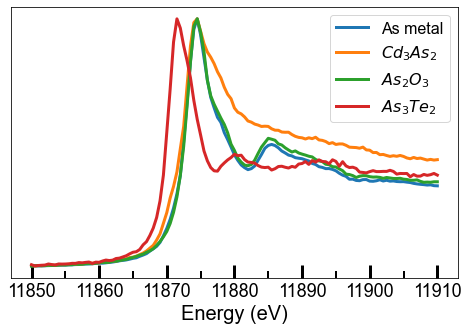

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

for i, label in enumerate(standards):
    x, y = get_xy_from_colms(dfs[i], 'Energy (keV)', 'I_0 (a.u.)')
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab20(i*2), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

2.7399999999997817


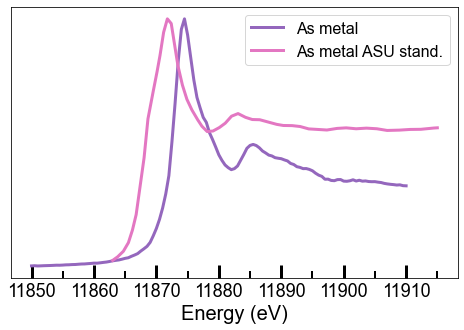

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[0], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(8), label=standards[0])

x2 = Energy
y2 = Refs[22]
y2 = y2 / np.max(y2)
label = 'As metal ASU stand.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(12), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

5.25


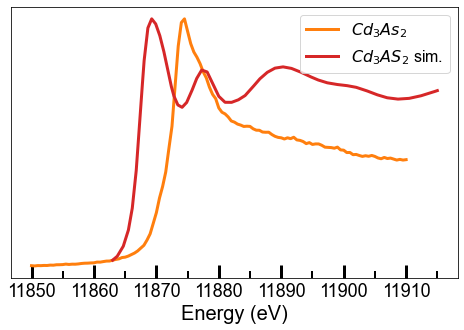

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[1], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(2), label=standards[1])

x2 = Energy
y2 = Refs[7]
y2 = y2 / np.max(y2)
label = '$Cd_3AS_2$ sim.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(6), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

2.7399999999997817


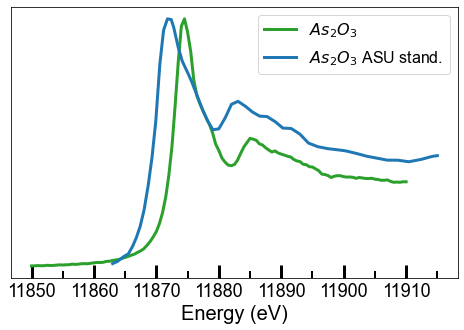

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[2], 'Energy (keV)', 'I_0 (a.u.)')
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(4), label=standards[2])

x2 = Energy
y2 = Refs[24]
y2 = y2 / np.max(y2)
label = '$As_2O_3$ ASU stand.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(0), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.show()

## Energy shift
A 2.73 eV energy shift will be applied to all simulated references so that is is aligned with the new experimental data.

In [6]:
def spectral_loss(x, spectrum, target, metric):
    return eval(metric)(x*spectrum, target)

def get_scale(spectrum, target, metric='mean_absolute_error'):
    alpha0 = 0.1
    alpha = minimize(spectral_loss, alpha0, args=(spectrum, target, metric))['x']
    return alpha

In [7]:
exp_energy = np.array(dfs[0]['Energy (keV)'], dtype=float)
print(min(exp_energy)*1000, max(exp_energy)*1000)
print(min(energy) + 2.74, max(energy) + 2.74)

11850.0 11910.0
11862.096 11933.503999999999


In [8]:
energy = energy + 2.74

bool_arr = exp_energy*1000 > 11865
Exp_Energy = exp_energy[bool_arr]*1000
Energy = Exp_Energy.copy()

interperlator = interp1d(energy, refs)

Refs = interperlator(Energy)

0.0
[0.32409579]


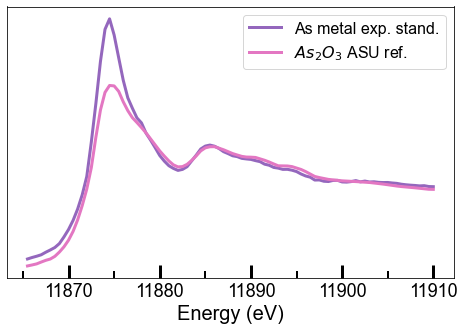

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[0], 'Energy (keV)', 'I_0 (a.u.)')
x1 = x1[bool_arr]
y1 = y1[bool_arr]
label = standards[0] + ' exp. stand.'

ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(8), label=label)

#x2 = Energy
#y2 = Refs[22]
#label = 'As metal ASU ref.'

x2 = Energy
y2 = Refs[24]
label = '$As_2O_3$ ASU ref.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

alpha = get_scale(y2, y1)
print(alpha)
y2 = alpha*y2

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(12), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.savefig('Figures/As_metal_exp_comparison.png', dpi=800, transparent=True)

0.0
[0.33828219]


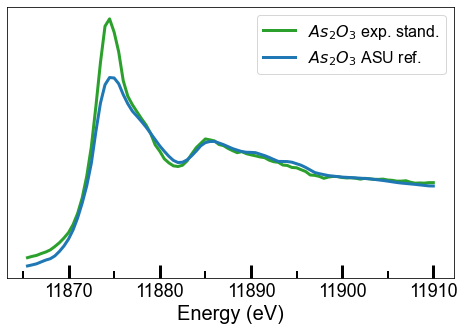

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

x1, y1 = get_xy_from_colms(dfs[2], 'Energy (keV)', 'I_0 (a.u.)')
x1 = x1[bool_arr]
y1 = y1[bool_arr]
label = standards[2] + ' exp. stand.'
ax.plot(x1, y1, '-', linewidth=3, c=plt.cm.tab20(4), label=label)

x2 = Energy
y2 = Refs[24]
#y2 = y2 / np.max(y2)
label = '$As_2O_3$ ASU ref.'

delta_E = x1[np.argmax(y1)] - x2[np.argmax(y2)]
print(delta_E)

alpha = get_scale(y2, y1)
print(alpha)
y2 = alpha*y2

ax.plot(x2, y2, '-', linewidth=3, c=plt.cm.tab20(0), label=label)

ax.legend(fontsize=16, loc='upper right')
format_axis(ax, ticks=(5,10))
plt.savefig('Figures/As2O3_exp_comparison.png', dpi=800, transparent=True)

References after energy shift and scaling

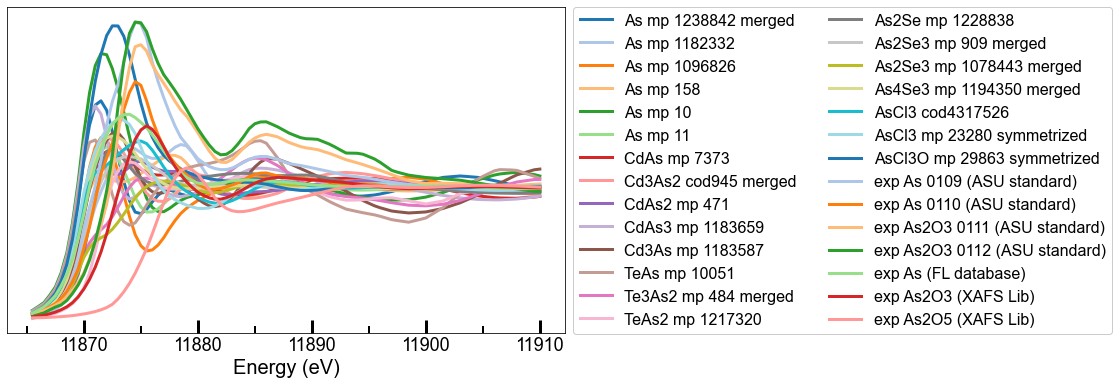

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, ref in enumerate(Refs):
    if i >= 20:
        c = i - 20
    else:
        c = i
    label = f'{data_columns[i]}'
    ax.plot(Energy, ref * alpha, '-', linewidth=3, c=plt.cm.tab20(c/19), label=label, alpha=1.)
ax.legend(fontsize=16, loc='center left', bbox_to_anchor=(1., .5), ncol=2, framealpha=1.)
format_axis(ax, ticks=(5,10))
plt.show()

# Visualize the Experimental Data

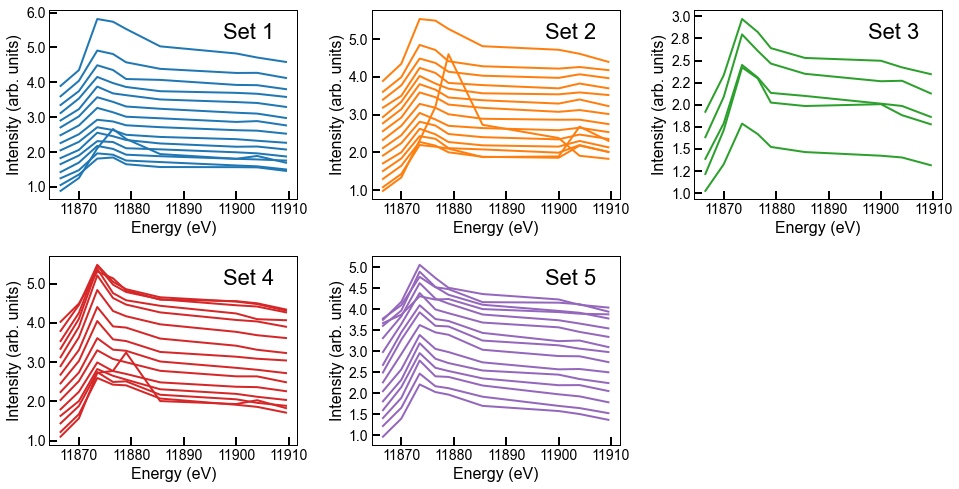

In [9]:
Energies = np.array([11.8665, 11.87, 11.8735, 11.8765, 11.879,
                     11.8855, 11.9, 11.904, 11.9095])
DATA = get_all_data(Energies)
# data is a list (by set) of a list (by pixel number) of dictaries (by xy pos)

nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(16, 8), nrows=nrows, ncols=ncols)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for Set in range(1, 7):
    row = (Set - 1) // ncols
    colm = (Set - 1) % ncols
    ax = axes[row, colm]
    if Set <= 5:
        setdata = DATA[Set] 
        for i, pt in enumerate(setdata):
            intensity = np.array(pt['I'], dtype=float)
            ax.plot(pt['E'], intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
        ax.annotate(f'Set {Set}', (0.7, 0.85), xycoords='axes fraction', fontsize=22)
        ax.set_ylabel("Intensity (arb. units)", fontsize=16)        
        ax.set_xlabel("Energy (eV)", fontsize=16)
        ax.tick_params(direction='in', width=2, length=8, which='major', axis='both')
        
        ax.set_xticks(np.array(ax.get_xticks())[1:-1])
        ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=14)
        
        ax.set_yticks(np.array(ax.get_yticks())[1:-1])
        ax.set_yticklabels(np.array(ax.get_yticks(), dtype=float), fontsize=14)
        
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        set_spine_width(ax, width=1.)
    else:
        ax.axis('off')

#plt.savefig('Figures/linescans.png', dpi=800, transparent=True)

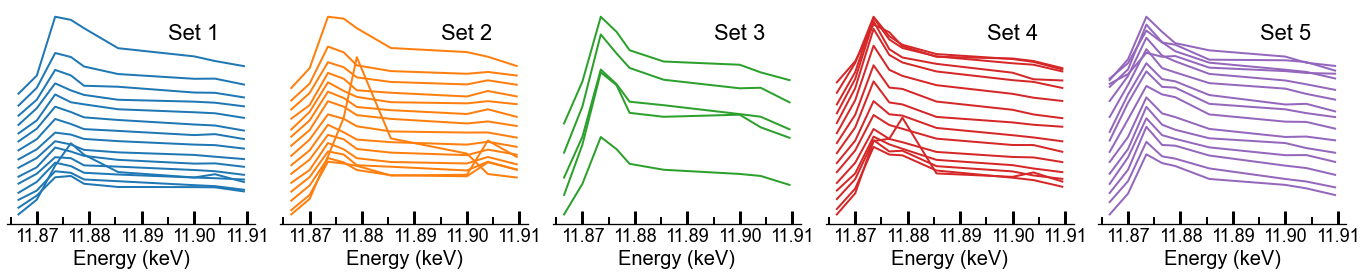

In [16]:
ncols = 5
fig, axes = plt.subplots(figsize=(24, 4), nrows=1, ncols=ncols)
plt.subplots_adjust(wspace=0.1, hspace=0.)

for Set in range(1, 6):
    colm = (Set - 1) % ncols
    ax = axes[colm]
    
    setdata = DATA[Set] 
    for i, pt in enumerate(setdata):
        intensity = np.array(pt['I'], dtype=float)
        ax.plot(np.array(pt['E']) / 1000, intensity / 1000 + i*0.2, '-', linewidth=2, c=plt.cm.tab10(Set - 1))
    
    ax.annotate(f'Set {Set}', (0.65, 0.85), xycoords='axes fraction', fontsize=22)
    
    ax.set_yticks([])
    ax.set_xlabel('Energy (keV)', fontsize=20)
    ax.xaxis.set_minor_locator(MultipleLocator(0.005))
    ax.xaxis.set_major_locator(MultipleLocator(0.010))
    ax.set_xticklabels(np.array(ax.get_xticks(), dtype=float), fontsize=18)
    ax.tick_params(direction='in', width=3, length=13, which='major')
    ax.tick_params(direction='in', width=2, length=7, which='minor')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    set_spine_width(ax, width=1.3)
    turn_off_spines(ax, spines=['top', 'left', 'right'])

plt.savefig('Figures/linescans_smushed.png', dpi=800, transparent=True, bbox_inches='tight', )

# Minimization of a reconstruction loss

In [165]:
X_energies = Energies * 1000
interperlator = interp1d(energy, refs)
Y_Refs = interperlator(X_energies)

In [125]:
kwargs = {'N': 30, 'scale': 0.0, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

## Determining the best $\lambda_1$

In [126]:
def get_spectral_loss(data, coeffs, Refs, metric, scale=None):
    preds, truths = [], []
    for i in range(data.shape[0]):
        pred = Refs.T @ coeffs[i]
        if scale is not None:
            pred = pred * scale[i]
        pred = pred - np.min(pred)
        preds.append(pred)
        true = data[i]
        true = true - np.min(true)
        truths.append(truths)
    return eval(metric)(pred, true)

In [128]:
lambdas = np.linspace(0.0, 0.4, 11)
print(lambdas)
Unscaled_errors = {}
Scaled_errors = {}
num_contribs_unscale = {}
num_contribs_scale = {}

for lambda1 in lambdas:
    tol = None
    metric = 'mean_squared_error'
    print(f'{lambda1}  ', end='\r')
    
    unscaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=False, tol=tol, metric=metric,
                                              lambda1=lambda1)
    unscale_err = get_spectral_loss(test_data, unscaled_coeffs, Y_Refs, metric, scale=None)
    Unscaled_errors[lambda1] = unscale_err
    num_contribs_unscale[lambda1] = np.average(np.sum(unscaled_coeffs != 0, axis=1), axis=0)

    scale, scaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=True, tol=tol, metric=metric,
                                                   lambda1=lambda1)
    scale_err = get_spectral_loss(test_data, scaled_coeffs, Y_Refs, metric, scale=scale)
    Scaled_errors[lambda1] = scale_err
    num_contribs_scale[lambda1] = np.average(np.sum(scaled_coeffs != 0, axis=1), axis=0)

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4 ]


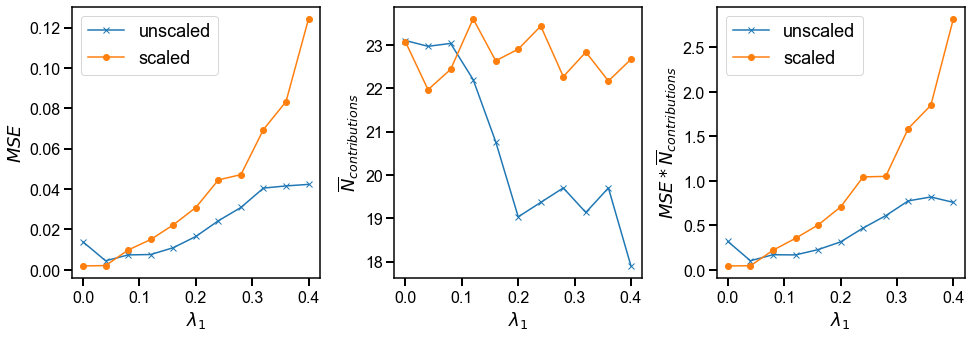

In [130]:
def plot_error_vs_lambda(Unscaled_errors, Scaled_errors,
                         num_contribs_unscale, num_contribs_scale):
    lambdas = np.array(list(Unscaled_errors.keys()))
    
    unscal = np.array(list(Unscaled_errors.values())) * 10
    unscal_contribs = np.array(list(num_contribs_unscale.values()))

    scal = np.array(list(Scaled_errors.values())) * 10
    scal_contribs = np.array(list(num_contribs_scale.values()))
    
    fig, axes = plt.subplots(figsize=(5*3 + 1, 5), ncols=3)
    plt.subplots_adjust(wspace=0.3)
    
    y1 = [unscal, unscal_contribs, unscal * unscal_contribs]
    y2 = [scal, scal_contribs, scal * scal_contribs]
    ylabels = ['$MSE$', '$\overline{N}_{contributions}$', '$MSE * \overline{N}_{contributions}$']

    for i, ax in enumerate(axes):
        ax.plot(lambdas, y1[i], 'x-', c=plt.cm.tab20(0), label='unscaled')
        ax.plot(lambdas, y2[i], 'o-', c=plt.cm.tab20(2), label='scaled')

        if i != 1:
            ax.legend(fontsize=18)
        ax.tick_params(direction='out', width=2, length=8, which='major', axis='both')
        ax.set_ylabel(ylabels[i], fontsize=18)
        ax.set_xlabel('$\lambda_1$', fontsize=18)
        plt.setp(ax.get_xticklabels(), fontsize=16)
        plt.setp(ax.get_yticklabels(), fontsize=16)
        set_spine_width(ax, width=1.5)

plot_error_vs_lambda(Unscaled_errors, Scaled_errors, num_contribs_unscale, num_contribs_scale)
plt.savefig(f'Figures/determining_lambda1.png', dpi=800, bbox_inches='tight', transparent=True)

# Examining tolerance

In [139]:
kwargs = {'N': 5, 'scale': 0.0, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Y_Refs, **kwargs)

In [152]:
tol = 0.08
metric = 'mean_squared_error'
lambda1 = 0.3
unscaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=False, tol=tol, metric=metric,
                                          lambda1=lambda1)
scale, scaled_coeffs = get_coeffs_from_spectra(test_data, Y_Refs, scaling=True, tol=tol, metric=metric,
                                               lambda1=lambda1)

tolerance too big. choosing max concentration.


mean squared error: 0.0005901148970122895
mean squared error: 0.011201875650101752


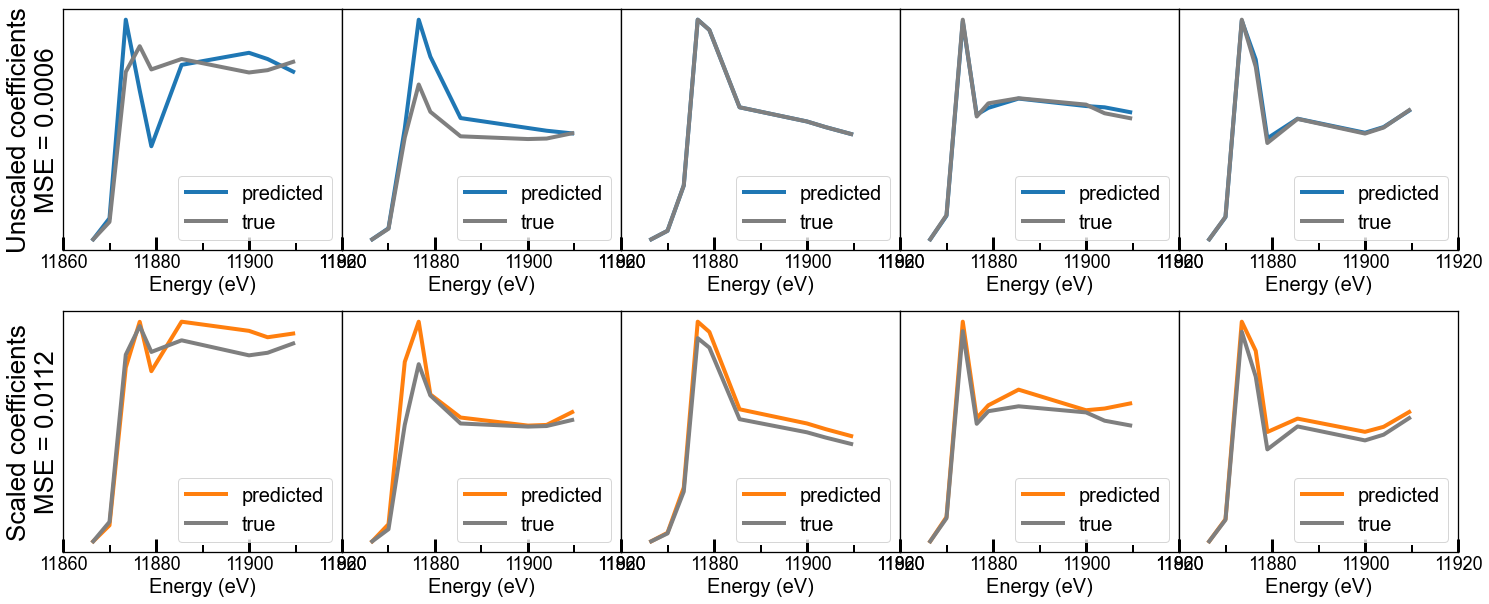

In [153]:
m = 5
fig, axes = plt.subplots(figsize=(5*m, 5*2), ncols=m, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0.25)

unscaled_error = plot_reconstructions((fig, axes[0, :]), test_data, unscaled_coeffs, m, X,
                                       Y_Refs, metric=metric, color=0)
scaled_error = plot_reconstructions((fig, axes[1, :]), test_data, scaled_coeffs, m, X,
                                     Y_Refs, scale=scale, metric=metric, color=2)

axes[0, 0].set_ylabel(f'Unscaled coefficients\nMSE = {unscaled_error:.4f}', fontsize=26)
axes[1, 0].set_ylabel(f'Scaled coefficients\nMSE = {scaled_error:.4f}', fontsize=26)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        set_spine_width(axes[i, j], width=1.3) 

plt.savefig(f'Figures/unscaled_vs_scaled_recon_spectra_tol_{tol}_lambda1_{lambda1}.png',
            dpi=800, bbox_inches='tight', transparent=True)

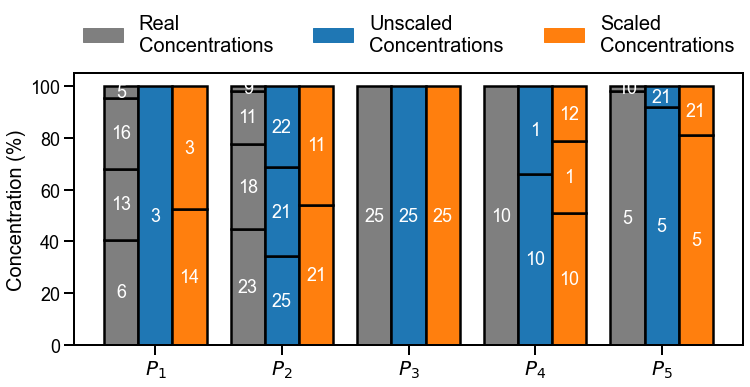

In [154]:
fig, ax = plt.subplots(figsize=(4*3, 5))
titles = ['Real\nConcentrations', 'Unscaled\nConcentrations', 'Scaled\nConcentrations']
coeffs = [test_coeffs, unscaled_coeffs, scaled_coeffs]
width = 0.27
offsets = [-width, 0, width]
colors = [14, 0, 2]

for i in range(3):
    if i == 2:
        ft = True
    else:
        ft = False
    make_conc_bar_chart((fig, ax), coeffs[i], data_columns, width=width,
                         offset=offsets[i], varcolor=colors[i], format_ticks=ft)
patches = [mpatches.Patch(color=plt.cm.tab20(colors[i]), label=titles[i]) for i in range(3)]
legend = ax.legend(handles=patches, frameon=False, fontsize=20, ncol=3,
                   loc='lower center', bbox_to_anchor=(0.5, 1.))
    
plt.savefig(f'Figures/coeff_bar_chart_tol_{tol}.png', dpi=800, bbox_inches='tight', transparent=True)

## Analyze affect of noise on error

In [132]:
utils = reload(utils)
from utils import *

In [137]:
metric = 'mean_squared_error'
lambda1 = 0.
noises = np.arange(0, 0.06, 0.01)
Errors = get_errors_with_different_noises(Y_Refs , noises=noises, metric=metric, lambda1=lambda1)

Noise: 0.0%
Noise: 1.0%
Noise: 2.0%
Noise: 3.0%
Noise: 4.0%
Noise: 5.0%


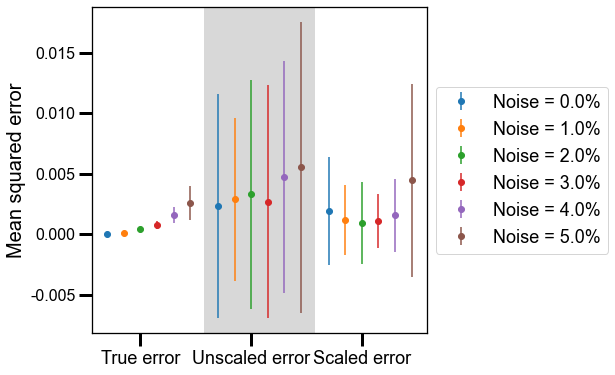

In [138]:
fig, ax = plt.subplots(figsize=(6, 6))

labels = ['True error', 'Unscaled error', 'Scaled error']
ax.axvspan(0.875, 1.875, fc=plt.cm.tab10(7), alpha=0.3)

for i, noise in enumerate(noises):
    errors = Errors[i]
    for j in range(errors.shape[0]):
        err = errors[j, :]
        if j == 0:
            label = f"Noise = {noise * 100}%"
        else:
            label = None
        plt.errorbar(np.array([j]) + i*0.15, np.average(err), yerr=np.std(err), fmt='o',
                     color=plt.cm.tab10(i), label=label)
        
plt.legend(fontsize=18, bbox_to_anchor=(1., 0.5), loc='center left')

ax.tick_params(direction='out', width=3, length=13, which='major', axis='both')

ax.set_ylabel('Mean squared error', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=16)

x_pos = np.array([i + 0.3 for i, _ in enumerate(labels)])
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.xticks(x_pos, labels, fontsize=18)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
set_spine_width(ax, width=1.3)

plt.savefig('Figures/minimization_optimization_noise_error.png', dpi=800,
            bbox_inches='tight', transparent=True)

# Find coeffs of experimental data using minimimzation with scaling

Set 1
Getting coeffs...
Setting up bar chart...
Setting up reconstruction plot...
mean absolute error: 361.6224658166876
mean absolute error: 361.6224658166876
mean absolute error: 361.6224658166876


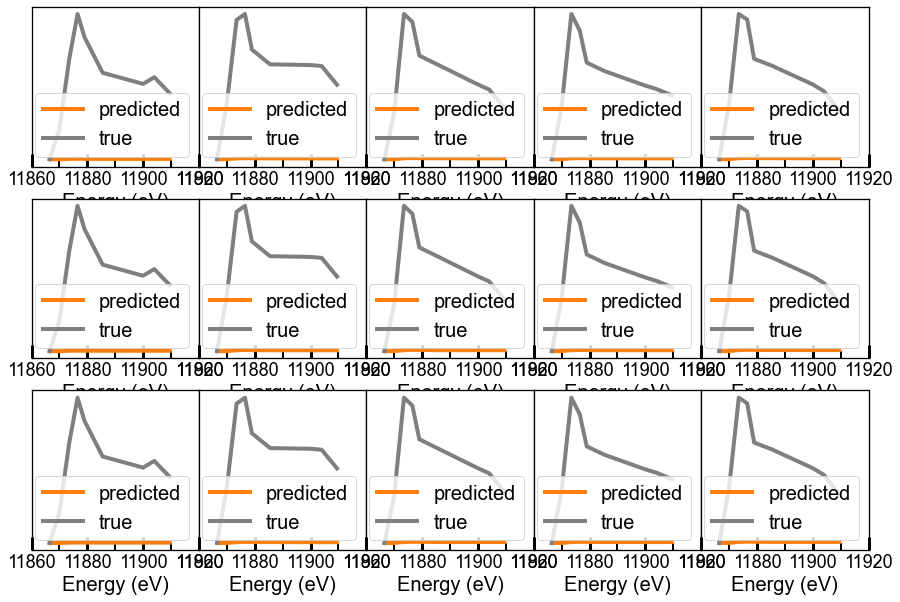

In [169]:
for Set in range(1, 6):
    print(f'Set {Set}')
    setdata = DATA[Set]
    Spectra = []
    for i, pt in enumerate(setdata):
        spectrum = np.array(pt['I'], dtype=float)
        Spectra.append(spectrum)
    Spectra = np.array(Spectra)
    print('Getting coeffs...')
    
    Scales, Coeffs = get_coeffs_from_spectra(Spectra, Y_Refs, scaling=True,
                                             lambda1=0.3, tol=0.01)
    print('Setting up bar chart...')
    """
    fig, ax = plt.subplots(figsize=(len(setdata), 5))
    plt.subplots_adjust(wspace=0, hspace=0.25)
    
    make_conc_bar_chart((fig, ax), Coeffs, data_columns, width=0.75, varcolor=0, format_ticks=False)
       
    m = Coeffs.shape[0]
    labels = ["$" + "P_{" + f"{i}" + "}$" for i in range(1, m + 1)]
    ax.set_xticks(np.arange(0, m))
    ax.set_xticklabels(labels, fontsize=18)
    
    plt.setp(ax.get_yticklabels(), fontsize=16)
    
    plt.title(f'Set {Set}', fontsize=20)
    plt.savefig(f'Figures/Set_{Set}_coeff_bar_chart.png', dpi=800, transparent=True)
    """
    print('Setting up reconstruction plot...')
    
    m = 5
    N = len(Spectra)
    nrows = N//m
    fig, axes = plt.subplots(figsize=(5*nrows, 5*2), ncols=m, nrows=nrows)
    plt.subplots_adjust(wspace=0, hspace=0.2)

    for i in range(axes.shape[0]):
        err = plot_reconstructions((fig, axes[i, :]), Spectra, Coeffs, m, X_energies,
                                       Y_Refs, scale=Scales, color=2)
        for j in range(axes.shape[1]):
            axes[i, j].set_ylabel(None)
            set_spine_width(axes[i, j], width=1.3) 

    plt.savefig(f'Figures/Set_{Set}_recon_plot.png',
                dpi=800, bbox_inches='tight', transparent=True)
    
    break

# Supervised Machine Learning
Train a model to correlate dataset of linear combinations of the selected energies to the coefficients of the components.

In [16]:
kwargs = {'N': 500, 'scale': 0.03, 'dropout': 0.9, 'training': False}
data, coeffs = generate_linear_combos(Refs, **kwargs)
kwargs = {'N': 50, 'scale': 0.03, 'dropout': 0.9, 'training': False}
test_data, test_coeffs = generate_linear_combos(Refs, **kwargs)